<a href="https://colab.research.google.com/github/hugosousa111/segmentacao_base_ph2/blob/main/resultados_experimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurações e Bibliotecas

In [1]:
# Acessa o Drive
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
from scipy import signal as sg
import cv2 as cv
import warnings
warnings.filterwarnings("ignore") 
import os
from IPython.display import clear_output
import pandas as pd
from collections import deque

# Funções Auxiliares

In [3]:
def plota(image, text="Imagem", colorida=False):
    fig = plt.figure(figsize=(9,3), dpi=100)
    a = fig.add_subplot(1,3,1)
    a.axis('off')
    if not colorida:
        plt.imshow(image, cmap=plt.cm.gray)
    else:
        plt.imshow(image[:,:,::-1])  #img colorida
    a.set_title(text)
    plt.show()

def just_save(image, caminho="", nome="name",  colorida=False):
    dpi = 80

    if not colorida:
        height, width = image.shape

        figsize = width / float(dpi), height / float(dpi)

        fig = plt.figure(figsize=figsize)
        ax = fig.add_axes([0, 0, 1, 1])
        ax.axis('off')

        ax.imshow(image, cmap=plt.cm.gray)
    else:
        height, width, nbands = image.shape

        figsize = width / float(dpi), height / float(dpi)

        fig = plt.figure(figsize=figsize)
        ax = fig.add_axes([0, 0, 1, 1])

        ax.axis('off')

        ax.imshow(image[:,:,::-1])
    ax.set(xlim=[-0.5, width - 0.5], ylim=[height - 0.5, -0.5], aspect=1)

    fig.savefig('/content/drive/My Drive/PH2_TCC/'+caminho+'/'+nome, dpi=dpi, transparent=True)
    plt.close(fig)

In [4]:
def get_names_images():
    filenames= os.listdir ("/content/drive/My Drive/PH2Dataset/PH2 Dataset images") 
    result = []
    for filename in filenames: 
        if os.path.isdir(os.path.join(os.path.abspath("/content/drive/My Drive/PH2Dataset/PH2 Dataset images"), filename)):
            result.append(filename)        
    result.sort()
    return result

imagens = get_names_images()
#imagens = imagens[0:30]
#imagens

In [5]:
def plota_grafico(X, Y, segmentador, indice, tipo, Y2 = 0): 
    plt.figure(figsize=(10,5))
    if Y2 == 0: 
        plt.errorbar(X, Y, marker='s',  fmt='o',mfc='red', ecolor='gray', capsize=5);
        for x,y in zip(X,Y):
            label = "{:.4f}".format(y)
            plt.annotate(label, (x,y), textcoords="offset points", xytext=(20,3), ha='center')
    else: 
        plt.errorbar(X, Y,yerr=Y2, marker='s',  fmt='o',mfc='red', ecolor='gray', capsize=5);
        for x,y in zip(X,Y):
            label = "{:.4f}".format(y)
            plt.annotate(label, (x,y), textcoords="offset points", xytext=(20,3), ha='center')
        for x,y,z in zip(X,Y, Y2):
            label = "{:.2f}".format(y+z)
            plt.annotate(label, (x,y+z), textcoords="offset points", xytext=(15,3), ha='center') 
        for x,y,z in zip(X,Y, Y2):
            label = "{:.2f}".format(y-z)
            plt.annotate(label, (x,y-z), textcoords="offset points", xytext=(15,3), ha='center') 
    
    plt.ylabel(indice)
    title = tipo+', Segmentador: '+segmentador+', Índice: '+indice
    plt.title(title)
    
    plt.margins(0.09,0)
    plt.xticks(rotation=0)
    plt.ylim(ymin=0, ymax=1.1)
    plt.grid(b='on')
    plt.show()

def gera_graficobar(X, melhores, inter, piores, segmentador, indice, melhor, pior):
    labels = X

    x = np.arange(len(labels))
    width = 0.27

    fig, ax = plt.subplots(figsize=(10, 5))
    rects1 = ax.bar(x - width, melhores, width, color='g', label='Melhores (>'+str(melhor)+')')
    rects2 = ax.bar(x, inter, width,label='Intermediários')
    rects3 = ax.bar(x + width, piores, width,color='r', label='Piores (<'+str(pior)+')')

    ax.set_ylabel('Amostras')
    title = 'Amostras por intervalo, segmentador: '+segmentador+', índice: '+indice
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    plt.margins(0.09,0)
    plt.xticks(rotation=0)
    plt.ylim(ymin=0, ymax=210)
    ax.set_axisbelow(True)
    plt.grid(b='on', color='gray', linestyle='--', linewidth=0.5)
    plt.show()

def melhor_pior(var, melhor, pior):
    melhores = len(var[var>melhor])
    piores = len(var[var<pior])
    intermediario = len(var) - melhores - piores

    return melhores,intermediario, piores

def maior_media_experimento(Y):
    if Y[0]>Y[1] and Y[0]>Y[2] and Y[0]>Y[3]:
        return 'P_P'
    elif Y[1]>Y[0] and Y[1]>Y[2] and Y[1]>Y[3]:
        return 'NP_P'
    elif Y[2]>Y[0] and Y[2]>Y[1] and Y[2]>Y[3]:
        return 'P_NP'
    else:
        return 'NP_NP'

def maior_melhor_experimento(Y):
    if Y[0]>Y[1] and Y[0]>Y[2] and Y[0]>Y[3]:
        return 'P_P'
    elif Y[1]>Y[0] and Y[1]>Y[2] and Y[1]>Y[3]:
        return 'NP_P'
    elif Y[2]>Y[0] and Y[2]>Y[1] and Y[2]>Y[3]:
        return 'P_NP'
    else:
        return 'NP_NP'

def plota_conjunto(var, min_max, z, segmentador, indice):
    if min_max == 'max':
        img_name = imagens[np.argmax(var)]
        print(indice+" -> ",np.max(var), "\n")
    else: 
        img_name = imagens[np.argmin(var)]
        print(indice+" -> ",np.min(var), "\n")
    print(img_name)

    imgOriginal = carrega_imagem_original(img_name, 1)
    plota(imgOriginal, text='Img Original', colorida=True)
    just_save(imgOriginal, caminho="outros", nome="imgOriginal",  colorida=True)

    if segmentador == 'Kmeans':
        if z == 'P_P':
            imgSegmentada = carrega_Resultados_Pre_kmeans_Pos(img_name)
        elif z == 'NP_P': 
            imgSegmentada = carrega_Resultados_NPre_kmeans_Pos(img_name)
        elif z == 'P_NP': 
            imgSegmentada = carrega_Resultados_Pre_kmeans_NPos(img_name)
        else: 
            imgSegmentada = carrega_Resultados_NPre_kmeans_NPos(img_name)
    elif segmentador == 'Otsu':
        if z == 'P_P':
            imgSegmentada = carrega_Resultados_Pre_Otsu_Pos(img_name)
        elif z == 'NP_P': 
            imgSegmentada = carrega_Resultados_NPre_Otsu_Pos(img_name)
        elif z == 'P_NP': 
            imgSegmentada = carrega_Resultados_Pre_Otsu_NPos(img_name)
        else: 
            imgSegmentada = carrega_Resultados_NPre_Otsu_NPos(img_name)
    elif segmentador == 'Binarização':
        if z == 'P_P':
            imgSegmentada = carrega_Resultados_Pre_binarizacao_Pos(img_name)
        elif z == 'NP_P': 
            imgSegmentada = carrega_Resultados_NPre_binarizacao_Pos(img_name)
        elif z == 'P_NP': 
            imgSegmentada = carrega_Resultados_Pre_binarizacao_NPos(img_name)
        else: 
            imgSegmentada = carrega_Resultados_NPre_binarizacao_NPos(img_name)
    elif segmentador == 'Binarização Gauss':
        if z == 'P_P':
            imgSegmentada = carrega_Resultados_Pre_binarizacao_adptativa_gauss_Pos(img_name)
        elif z == 'NP_P': 
            imgSegmentada = carrega_Resultados_NPre_binarizacao_adptativa_gauss_Pos(img_name)
        elif z == 'P_NP': 
            imgSegmentada = carrega_Resultados_Pre_binarizacao_adptativa_gauss_NPos(img_name)
        else: 
            imgSegmentada = carrega_Resultados_NPre_binarizacao_adptativa_gauss_NPos(img_name)
    elif segmentador == 'Binarização Mean':
        if z == 'P_P':
            imgSegmentada = carrega_Resultados_Pre_binarizacao_adptativa_mean_Pos(img_name)
        elif z == 'NP_P': 
            imgSegmentada = carrega_Resultados_NPre_binarizacao_adptativa_mean_Pos(img_name)
        elif z == 'P_NP': 
            imgSegmentada = carrega_Resultados_Pre_binarizacao_adptativa_mean_NPos(img_name)
        else: 
            imgSegmentada = carrega_Resultados_NPre_binarizacao_adptativa_mean_NPos(img_name)
    elif segmentador == 'Crescimento de Região':
        if z == 'P_P':
            imgSegmentada = carrega_Resultados_Pre_crescimento_de_regiao_Pos(img_name)
        elif z == 'NP_P': 
            imgSegmentada = carrega_Resultados_NPre_crescimento_de_regiao_Pos(img_name)
        elif z == 'P_NP': 
            imgSegmentada = carrega_Resultados_Pre_crescimento_de_regiao_NPos(img_name)
        else: 
            imgSegmentada = carrega_Resultados_NPre_crescimento_de_regiao_NPos(img_name)
    elif segmentador == '---':
        if z == 'Branco':
            imgSegmentada = carrega_Resultados_tudo_branco(img_name)
        elif z == 'Preta': 
            imgSegmentada = carrega_Resultados_tudo_preto(img_name)
        else: 
            imgSegmentada = carrega_Resultados_tudo_com_filtro(img_name)
    
    plota(imgSegmentada, text='Img Segmentada')
    just_save(imgSegmentada, caminho="outros", nome="imgSegmentada")

    imgLesion = carrega_imagem_lesion(img_name)
    plota(imgLesion, text='Img Especialista')
    just_save(imgLesion, caminho="outros", nome="imgLesion")


def gera_tudo(p_p,np_p,p_np,np_np, segmentador, indice, melhor=0.8, pior=0.35):
    X = ['P-P', 'NP-P', 'P-NP', 'NP-NP']
    Y = [np.mean(p_p),np.mean(np_p),np.mean(p_np),np.mean(np_np)]
    Y_std = [np.std(p_p),np.std(np_p),np.std(p_np),np.std(np_np)]
    Y_max = [np.max(p_p),np.max(np_p),np.max(p_np),np.max(np_np)]
    Y_min = [np.min(p_p),np.min(np_p),np.min(p_np),np.min(np_np)]

    x_ = 25
    y_ = -3
    plt.figure(figsize=(10,5))
    plt.errorbar(X, Y_max, marker='^',  label='Melhor Caso', fmt='o',mfc='g', ecolor='gray', capsize=5);
    for x,y in zip(X,Y_max):
        label = "{:.4f}".format(y)
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(x_,y_-1), ha='center')
    plt.errorbar(X, Y_min, marker='v',  label='Pior Caso', fmt='o',mfc='red', ecolor='gray', capsize=5);
    for x,y in zip(X,Y_min):
        label = "{:.4f}".format(y)
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(x_,y_-1), ha='center')
    plt.errorbar(X, Y, marker='s',   label='Média', fmt='o', ecolor='gray', capsize=5);
    for x,y in zip(X,Y):
        label = "\u03BC = {:.4f}".format(y)
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(x_+10,y_), ha='center')
    for x,y,z in zip(X,Y, Y_std):
        label = "(\u03C3 = {:.4f})".format(z)
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(x_+11,y_-10), ha='center') 
    
    plt.ylabel(indice)
    title = "tipo"+', Segmentador: '+"segmentador"+', Índice: '+indice
    plt.title(title)
    
    plt.margins(0.4,0)
    plt.xticks(rotation=0)
    plt.ylim(ymin=-0.05, ymax=1.3)
    plt.xlim(xmin=-0.5, xmax=4)
    plt.grid(b='on', color='gray', linestyle='--', linewidth=0.5)
    plt.legend(loc='upper right')
    plt.title("")
    plt.savefig('/content/drive/My Drive/PH2_TCC/outros/'+segmentador+'_'+indice+'_T', dpi=80, transparent=True)
    plt.show()
    
    m_p_p, i_p_p, p_p_p = melhor_pior(p_p, melhor, pior)
    m_np_p, i_np_p, p_np_p = melhor_pior(np_p, melhor, pior)
    m_p_np, i_p_np, p_p_np = melhor_pior(p_np, melhor, pior)
    m_np_np, i_np_np, p_np_np = melhor_pior(np_np, melhor, pior)

    melhores = np.concatenate((m_p_p, m_np_p, m_p_np, m_np_np), axis=None)
    inter = np.concatenate((i_p_p, i_np_p, i_p_np, i_np_np), axis=None)
    piores = np.concatenate((p_p_p, p_np_p, p_p_np, p_np_np), axis=None)

    gera_graficobar(X, melhores, inter, piores, segmentador, indice, melhor, pior)

    print('\n'+segmentador+' + ' +indice+': ')
    print("Maior Média: ")
    z = maior_media_experimento(Y)
    print(z)
    print("Maior número de melhores amostras: ")
    print(maior_melhor_experimento(melhores))

    if z == 'P_P':
        var = p_p
    elif z == 'NP_P': 
        var = np_p
    elif z == 'P_NP':
        var = p_np
    else:
        var = np_np

    print('\nPior caso: ')
    plota_conjunto(var, 'min', z, segmentador,  indice)
    
    print('\nMelhor caso: ')
    plota_conjunto(var, 'max', z, segmentador, indice)
    

In [6]:
def gera_tudo_controle(branco,preta,filtro, segmentador, indice, melhor=0.8, pior=0.35):
    X = ['Branco', 'Preta', 'Filtro']
    Y = [np.mean(branco),np.mean(preta),np.mean(filtro)]
    Y_std = [np.std(branco),np.std(preta),np.std(filtro)]
    Y_max = [np.max(branco),np.max(preta),np.max(filtro)]
    Y_min = [np.min(branco),np.min(preta),np.min(filtro)]

    plota_grafico(X, Y, segmentador, indice, 'Média e Desvio Padrão', Y_std)
    
    plota_grafico(X, Y_max, segmentador, indice, 'Máximo')

    plota_grafico(X, Y_min, segmentador, indice, 'Mínimo')

    m_branco, i_branco, p_branco = melhor_pior(branco, melhor, pior)
    m_preta, i_preta, p_preta = melhor_pior(preta, melhor, pior)
    m_filtro, i_filtro, p_filtro = melhor_pior(filtro, melhor, pior)
    
    melhores = np.concatenate((m_branco, m_preta, m_filtro), axis=None)
    inter = np.concatenate((i_branco, i_preta, i_filtro), axis=None)
    piores = np.concatenate((p_branco, p_preta, p_filtro), axis=None)

    gera_graficobar(X, melhores, inter, piores, segmentador, indice, melhor, pior)

    print(indice+': ')
    print("Maior Média: ")
    if Y[0]>Y[1] and Y[0]>Y[2]:
        var = branco
        z = 'Branco'
    elif Y[1]>Y[0] and Y[1]>Y[2]:
        var = preto
        z = 'Preto'
    else:
        var = filtro
        z = 'Filtro'
    print(z)
    print("Maior número de melhores amostras: ")
    if melhores[0]>melhores[1] and melhores[0]>melhores[2]:
        print('Branco')
    elif melhores[1]>melhores[0] and melhores[1]>melhores[2]:
        print('Preto')
    else:
        print('Filtro')    
    
    print('\nPior caso: ')
    plota_conjunto(var, 'min', z, segmentador,  indice)
    
    print('\nMelhor caso: ')
    plota_conjunto(var, 'max', z, segmentador,  indice)

In [7]:
def gera_tudo_melhores(X, kmeans, otsu, bin, binG, binM, cr, indice, melhor=0.8, pior=0.35):
    Y = [np.mean(kmeans),np.mean(otsu),np.mean(bin),np.mean(binG),np.mean(binM),np.mean(cr)]
    Y_std = [np.std(kmeans),np.std(otsu),np.std(bin),np.std(binG),np.std(binM),np.std(cr)]
    Y_max = [np.max(kmeans),np.max(otsu),np.max(bin),np.max(binG),np.max(binM),np.max(cr)]
    Y_min = [np.min(kmeans),np.min(otsu),np.min(bin),np.min(binG),np.min(binM),np.min(cr)]

    x_ = 25
    y_ = -3
    plt.figure(figsize=(10,5))
    plt.errorbar(X, Y_max, marker='^',  label='Melhor Caso', fmt='o',mfc='g', ecolor='gray', capsize=5);
    for x,y in zip(X,Y_max):
        label = "{:.4f}".format(y)
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(x_,y_-1), ha='center')
    plt.errorbar(X, Y_min, marker='v',  label='Pior Caso', fmt='o',mfc='red', ecolor='gray', capsize=5);
    for x,y in zip(X,Y_min):
        label = "{:.4f}".format(y)
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(x_,y_-1), ha='center')
    plt.errorbar(X, Y, marker='s',   label='Média', fmt='o', ecolor='gray', capsize=5);
    for x,y in zip(X,Y):
        label = "\u03BC = {:.4f}".format(y)
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(x_+10,y_), ha='center')
    for x,y,z in zip(X,Y, Y_std):
        label = "(\u03C3 = {:.4f})".format(z)
        plt.annotate(label, (x,y), textcoords="offset points", xytext=(x_+11,y_-10), ha='center') 

    plt.ylabel(indice)
    title = "tipo"+', Segmentador: '+"segmentador"+', Índice: '+indice
    plt.title(title)
    
    plt.margins(0.4,0)
    plt.xticks(rotation=0)
    plt.ylim(ymin=-0.05, ymax=1.3)
    plt.xlim(xmin=-0.5, xmax=6)
    plt.grid(b='on', color='gray', linestyle='--', linewidth=0.5)
    plt.legend(loc='upper right')
    plt.title("")
    plt.savefig('/content/drive/My Drive/PH2_TCC/outros/Melhores', dpi=80, transparent=True)
    plt.show()
    
    m_kmeans, i_kmeans, p_kmeans = melhor_pior(kmeans, melhor, pior)
    m_otsu, i_otsu, p_otsu = melhor_pior(otsu, melhor, pior)
    m_bin, i_bin, p_bin = melhor_pior(bin, melhor, pior)
    m_binG, i_binG, p_binG = melhor_pior(binG, melhor, pior)
    m_binM, i_binM, p_binM = melhor_pior(binM, melhor, pior)
    m_cr, i_cr, p_cr = melhor_pior(cr, melhor, pior)

    melhores = np.concatenate((m_kmeans, m_otsu, m_bin, m_binG, m_binM, m_cr), axis=None)
    inter = np.concatenate((i_kmeans, i_otsu, i_bin, i_binG, i_binM, i_cr), axis=None)
    piores = np.concatenate((p_kmeans, p_otsu, p_bin, p_binG, p_binM, p_cr), axis=None)

    gera_graficobar(X, melhores, inter, piores, 'Melhores', indice, melhor, pior)

    print(indice+': ')
    print("Maior Média: ")
    if Y[0]>Y[1] and Y[0]>Y[2] and Y[0]>Y[3] and Y[0]>Y[4] and Y[0]>Y[5]:
        var = kmeans
        z = X[0].split(' ')[1]
        segmentador = 'Kmeans'
    elif Y[1]>Y[0] and Y[1]>Y[2] and Y[1]>Y[3] and Y[1]>Y[4] and Y[1]>Y[5]:
        var = otsu
        z = X[1].split(' ')[1]
        segmentador = 'Otsu'
    elif Y[2]>Y[0] and Y[2]>Y[1] and Y[2]>Y[3] and Y[2]>Y[4] and Y[2]>Y[5]:
        var = bin
        z = X[2].split(' ')[1]
        segmentador = 'Binarização'
    elif Y[3]>Y[0] and Y[3]>Y[1] and Y[3]>Y[2] and Y[3]>Y[4] and Y[3]>Y[5]:
        var = binG
        z = X[3].split(' ')[1]
        segmentador = 'Binarização Gauss'
    elif Y[4]>Y[0] and Y[4]>Y[1] and Y[4]>Y[2] and Y[4]>Y[3] and Y[4]>Y[5]:
        var = binM
        z = X[4].split(' ')[1]
        segmentador = 'Binarização Mean'
    else:
        var = cr
        z = X[5].split(' ')[1]
        segmentador = 'Crescimento de Região'
    
    print(segmentador)
    print(z)
    
    print("Maior número de melhores amostras: ")
    if melhores[0]>melhores[1] and melhores[0]>melhores[2] and melhores[0]>melhores[3] and melhores[0]>melhores[4] and melhores[0]>melhores[5]:
        print('Kmeans')
    elif melhores[1]>melhores[0] and melhores[1]>melhores[2] and melhores[1]>melhores[3] and melhores[1]>melhores[4] and melhores[1]>melhores[5]:
        print('Otsu')
    elif melhores[2]>melhores[0] and melhores[2]>melhores[1] and melhores[2]>melhores[3] and melhores[2]>melhores[4] and melhores[2]>melhores[5]:
        print('Binarização')
    elif melhores[3]>melhores[0] and melhores[3]>melhores[1] and melhores[3]>melhores[2] and melhores[3]>melhores[4] and melhores[3]>melhores[5]:
        print('Binarização Gauss')
    elif melhores[4]>melhores[0] and melhores[4]>melhores[1] and melhores[4]>melhores[2] and melhores[4]>melhores[3] and melhores[4]>melhores[5]:
        print('Binarização Mean')
    else:
        print('Crescimento de Região')
    
    print('\nPior caso: ')
    plota_conjunto(var, 'min', z, segmentador,  indice)
    
    print('\nMelhor caso: ')
    plota_conjunto(var, 'max', z, segmentador,  indice)

In [8]:
def gera_graficobar(X, melhores, inter, piores, segmentador, indice, melhor, pior):
    labels = X

    x = np.arange(len(labels)) 
    width = 0.27

    fig, ax = plt.subplots(figsize=(10, 5))
    rects1 = ax.bar(x - width, melhores, width, color='g', label='Melhores (>'+str(melhor)+')')
    rects2 = ax.bar(x, inter, width,label='Intermediários')
    rects3 = ax.bar(x + width, piores, width,color='r', label='Piores (<'+str(pior)+')')

    ax.set_ylabel('Amostras')
    title = 'Amostras por intervalo, segmentador: '+segmentador+', índice: '+indice
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    plt.margins(0.09,0)
    plt.xticks(rotation=0)
    plt.ylim(ymin=0, ymax=210)
    ax.set_axisbelow(True)
    plt.grid(b='on', color='gray', linestyle='--', linewidth=0.5)
    plt.show()


In [9]:
def carrega_imagem_original(image, color=0):
    img = cv.imread('/content/drive/My Drive/PH2Dataset/PH2 Dataset images/'+image+'/'+image+'_Dermoscopic_Image/'+image+'.bmp', color)
    return img

def carrega_imagem_lesion(image, color=0):
    img = cv.imread('/content/drive/My Drive/PH2Dataset/PH2 Dataset images/'+image+'/'+image+'_lesion/'+image+'_lesion.bmp', color)
    return img
    
def carrega_imagem_processada(image, color=0):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Pre_Processadas_Black_Hat/'+image+'.png', color)
    return img

def carrega_Resultados_NPre_kmeans_Pos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_NPre_kmeans_Pos/'+image+'.png', 0)
    return img

def carrega_Resultados_Pre_kmeans_Pos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_Pre_kmeans_Pos/'+image+'.png', 0)
    return img

def carrega_Resultados_Pre_kmeans_NPos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_Pre_kmeans_NPos/'+image+'.png', 0)
    return img

def carrega_Resultados_NPre_kmeans_NPos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_NPre_kmeans_NPos/'+image+'.png', 0)
    return img

def carrega_Resultados_NPre_Otsu_Pos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_NPre_Otsu_Pos/'+image+'.png', 0)
    return img

def carrega_Resultados_Pre_Otsu_Pos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_Pre_Otsu_Pos/'+image+'.png', 0)
    return img

def carrega_Resultados_Pre_Otsu_NPos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_Pre_Otsu_NPos/'+image+'.png', 0)
    return img

def carrega_Resultados_NPre_Otsu_NPos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_NPre_Otsu_NPos/'+image+'.png', 0)
    return img

def carrega_Resultados_NPre_binarizacao_Pos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_NPre_binarizacao_Pos/'+image+'.png', 0)
    return img

def carrega_Resultados_Pre_binarizacao_Pos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_Pre_binarizacao_Pos/'+image+'.png', 0)
    return img

def carrega_Resultados_Pre_binarizacao_NPos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_Pre_binarizacao_NPos/'+image+'.png', 0)
    return img

def carrega_Resultados_NPre_binarizacao_NPos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_NPre_binarizacao_NPos/'+image+'.png', 0)
    return img

def carrega_Resultados_tudo_branco(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_tudo_branco/'+image+'.png', 0)
    return img

def carrega_Resultados_tudo_preto(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_tudo_preto/'+image+'.png', 0)
    return img

def carrega_Resultados_tudo_com_filtro(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_tudo_com_filtro/'+image+'.png', 0)
    return img

def carrega_Resultados_NPre_binarizacao_adptativa_gauss_Pos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_NPre_binarizacao_adptativa_gauss_Pos/'+image+'.png', 0)
    return img

def carrega_Resultados_Pre_binarizacao_adptativa_gauss_Pos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_Pre_binarizacao_adptativa_gauss_Pos/'+image+'.png', 0)
    return img

def carrega_Resultados_Pre_binarizacao_adptativa_gauss_NPos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_Pre_binarizacao_adptativa_gauss_NPos/'+image+'.png', 0)
    return img

def carrega_Resultados_NPre_binarizacao_adptativa_gauss_NPos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_NPre_binarizacao_adptativa_gauss_NPos/'+image+'.png', 0)
    return img

def carrega_Resultados_NPre_binarizacao_adptativa_mean_Pos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_NPre_binarizacao_adptativa_mean_Pos/'+image+'.png', 0)
    return img

def carrega_Resultados_Pre_binarizacao_adptativa_mean_Pos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_Pre_binarizacao_adptativa_mean_Pos/'+image+'.png', 0)
    return img

def carrega_Resultados_Pre_binarizacao_adptativa_mean_NPos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_Pre_binarizacao_adptativa_mean_NPos/'+image+'.png', 0)
    return img

def carrega_Resultados_NPre_binarizacao_adptativa_mean_NPos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_NPre_binarizacao_adptativa_mean_NPos/'+image+'.png', 0)
    return img

def carrega_Resultados_NPre_crescimento_de_regiao_Pos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_NPre_crescimento_de_regiao_Pos/'+image+'.png', 0)
    return img

def carrega_Resultados_Pre_crescimento_de_regiao_Pos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_Pre_crescimento_de_regiao_Pos/'+image+'.png', 0)
    return img

def carrega_Resultados_Pre_crescimento_de_regiao_NPos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_Pre_crescimento_de_regiao_NPos/'+image+'.png', 0)
    return img

def carrega_Resultados_NPre_crescimento_de_regiao_NPos(image):
    img = cv.imread('/content/drive/My Drive/PH2_TCC/Resultados_NPre_crescimento_de_regiao_NPos/'+image+'.png', 0)
    return img


# Gráfico: 


## Recupera indices

In [10]:
kmeans_p_p_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/kmeans_p_p_j.txt')
kmeans_np_p_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/kmeans_np_p_j.txt')
kmeans_p_np_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/kmeans_p_np_j.txt')
kmeans_np_np_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/kmeans_np_np_j.txt')
#############
otsu_p_p_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/otsu_p_p_j.txt')
otsu_np_p_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/otsu_np_p_j.txt')
otsu_p_np_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/otsu_p_np_j.txt')
otsu_np_np_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/otsu_np_np_j.txt')
#############
bin_p_p_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/bin_p_p_j.txt')
bin_np_p_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/bin_np_p_j.txt')
bin_p_np_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/bin_p_np_j.txt')
bin_np_np_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/bin_np_np_j.txt')
#############
binG_p_p_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/binG_p_p_j.txt')
binG_np_p_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/binG_np_p_j.txt')
binG_p_np_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/binG_p_np_j.txt')
binG_np_np_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/binG_np_np_j.txt')
#############
binM_p_p_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/binM_p_p_j.txt')
binM_np_p_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/binM_np_p_j.txt')
binM_p_np_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/binM_p_np_j.txt')
binM_np_np_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/binM_np_np_j.txt')
#############
cr_p_p_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/cr_p_p_j.txt')
cr_np_p_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/cr_np_p_j.txt')
cr_p_np_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/cr_p_np_j.txt')
cr_np_np_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/cr_np_np_j.txt')
#############
con_branco_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/con_branco_j.txt')
con_preta_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/con_preta_j.txt')
con_filtro_j = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_j/con_filtro_j.txt')

In [11]:
kmeans_p_p_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/kmeans_p_p_d.txt')
kmeans_np_p_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/kmeans_np_p_d.txt')
kmeans_p_np_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/kmeans_p_np_d.txt')
kmeans_np_np_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/kmeans_np_np_d.txt')
#############
otsu_p_p_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/otsu_p_p_d.txt')
otsu_np_p_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/otsu_np_p_d.txt')
otsu_p_np_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/otsu_p_np_d.txt')
otsu_np_np_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/otsu_np_np_d.txt')
#############
bin_p_p_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/bin_p_p_d.txt')
bin_np_p_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/bin_np_p_d.txt')
bin_p_np_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/bin_p_np_d.txt')
bin_np_np_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/bin_np_np_d.txt')
#############
binG_p_p_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/binG_p_p_d.txt')
binG_np_p_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/binG_np_p_d.txt')
binG_p_np_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/binG_p_np_d.txt')
binG_np_np_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/binG_np_np_d.txt')
#############
binM_p_p_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/binM_p_p_d.txt')
binM_np_p_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/binM_np_p_d.txt')
binM_p_np_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/binM_p_np_d.txt')
binM_np_np_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/binM_np_np_d.txt')
#############
cr_p_p_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/cr_p_p_d.txt')
cr_np_p_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/cr_np_p_d.txt')
cr_p_np_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/cr_p_np_d.txt')
cr_np_np_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/cr_np_np_d.txt')
#############
con_branco_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/con_branco_d.txt')
con_preta_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/con_preta_d.txt')
con_filtro_d = np.loadtxt('/content/drive/My Drive/PH2_TCC/variaveis_d/con_filtro_d.txt')

imagens = get_names_images()

## Kmeans

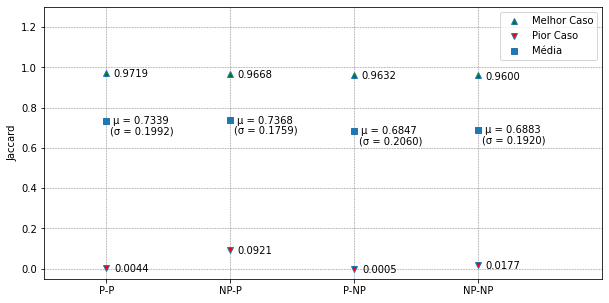

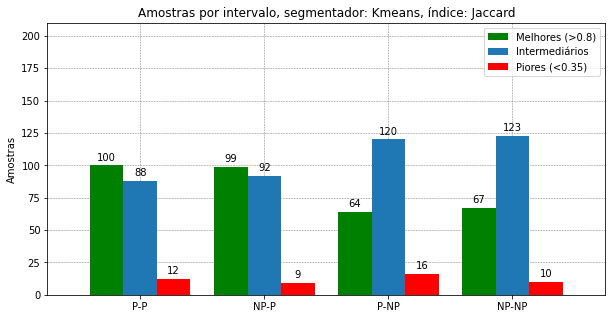


Kmeans + Jaccard: 
Maior Média: 
NP_P
Maior número de melhores amostras: 
P_P

Pior caso: 
Jaccard ->  0.09212607826164822 

IMD035


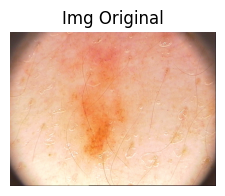

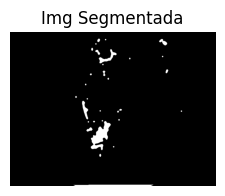

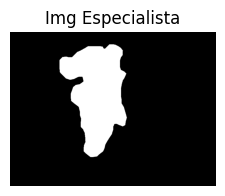


Melhor caso: 
Jaccard ->  0.9668292947362714 

IMD057


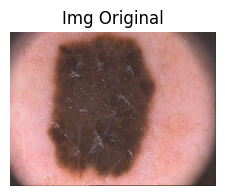

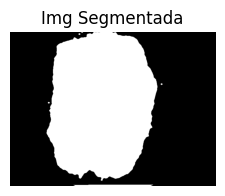

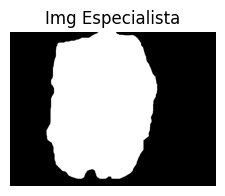

In [12]:
gera_tudo(kmeans_p_p_j,kmeans_np_p_j,kmeans_p_np_j,kmeans_np_np_j, 'Kmeans', 'Jaccard')

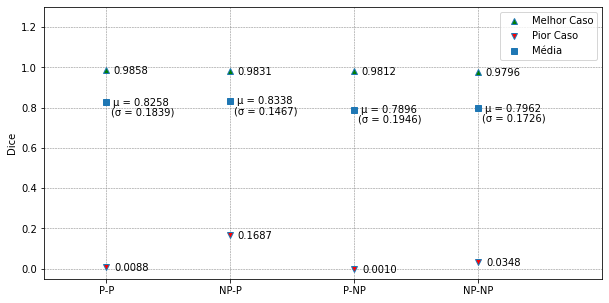

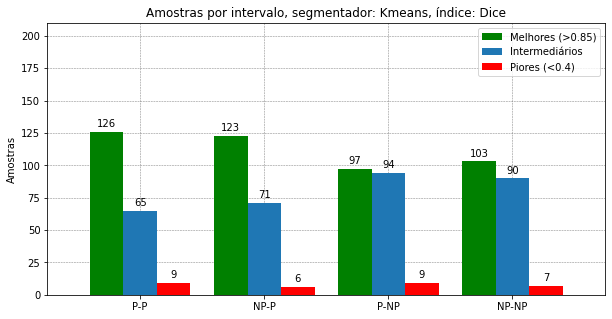


Kmeans + Dice: 
Maior Média: 
NP_P
Maior número de melhores amostras: 
P_P

Pior caso: 
Dice ->  0.16870960248158626 

IMD035


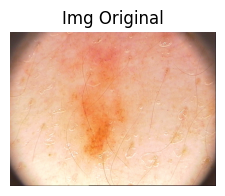

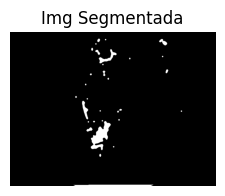

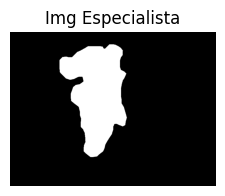


Melhor caso: 
Dice ->  0.9831349343064486 

IMD057


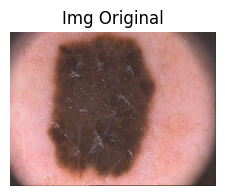

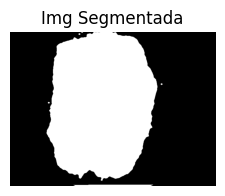

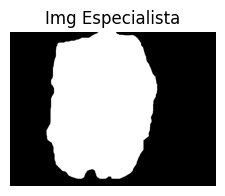

In [13]:
gera_tudo(kmeans_p_p_d,kmeans_np_p_d,kmeans_p_np_d,kmeans_np_np_d, 'Kmeans', 'Dice', melhor=0.85, pior=0.4)

## Otsu

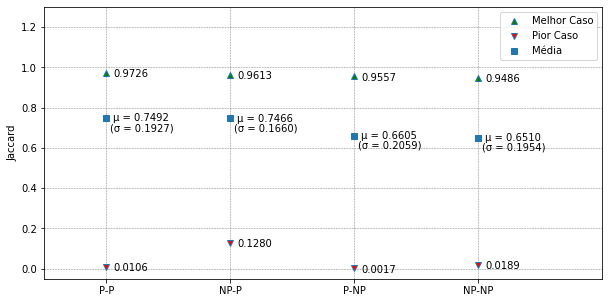

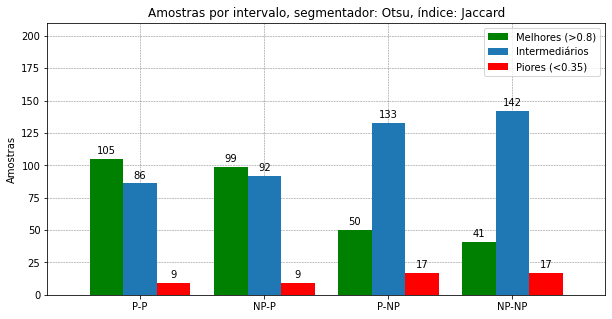


Otsu + Jaccard: 
Maior Média: 
P_P
Maior número de melhores amostras: 
P_P

Pior caso: 
Jaccard ->  0.010611514533613533 

IMD010


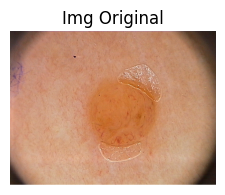

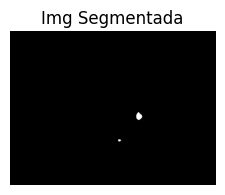

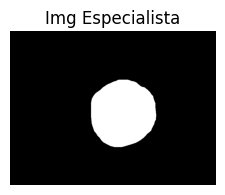


Melhor caso: 
Jaccard ->  0.972570297159672 

IMD057


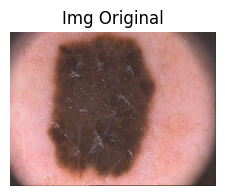

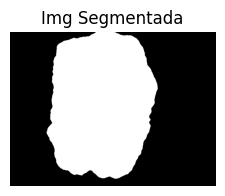

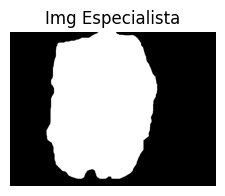

In [14]:
gera_tudo(otsu_p_p_j,otsu_np_p_j,otsu_p_np_j,otsu_np_np_j, 'Otsu', 'Jaccard')

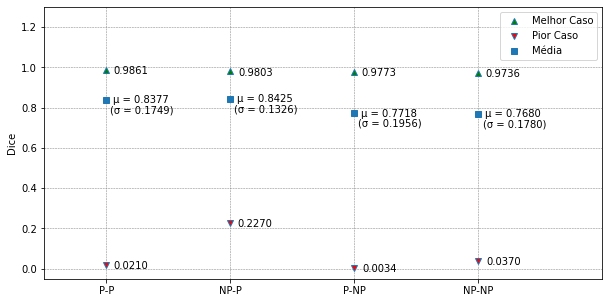

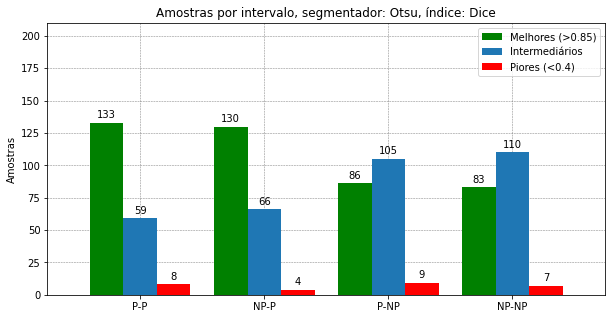


Otsu + Dice: 
Maior Média: 
NP_P
Maior número de melhores amostras: 
P_P

Pior caso: 
Dice ->  0.2269818535405963 

IMD035


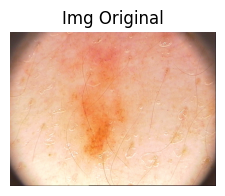

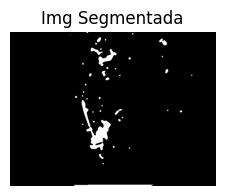

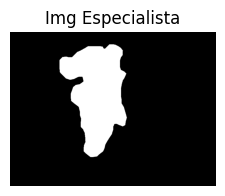


Melhor caso: 
Dice ->  0.9802712970363152 

IMD057


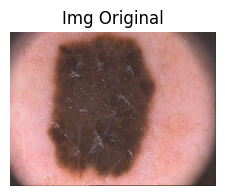

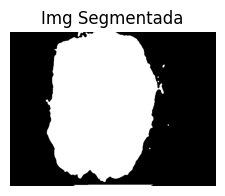

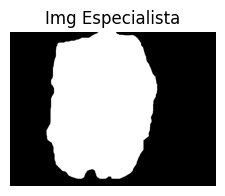

In [15]:
gera_tudo(otsu_p_p_d,otsu_np_p_d,otsu_p_np_d,otsu_np_np_d, 'Otsu', 'Dice', melhor=0.85, pior=0.40)

## Binarização

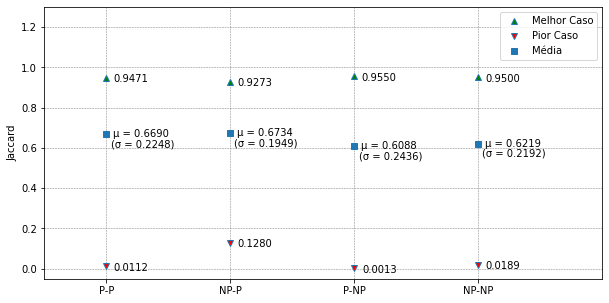

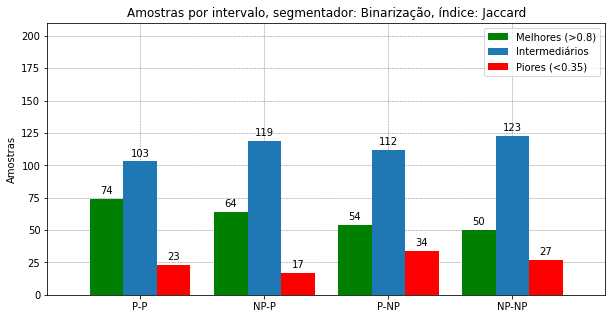


Binarização + Jaccard: 
Maior Média: 
NP_P
Maior número de melhores amostras: 
P_P

Pior caso: 
Jaccard ->  0.12802003972371268 

IMD035


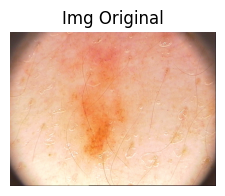

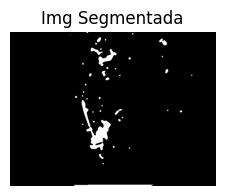

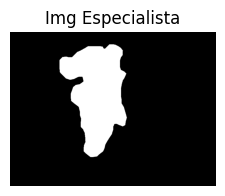


Melhor caso: 
Jaccard ->  0.9273275906331584 

IMD347


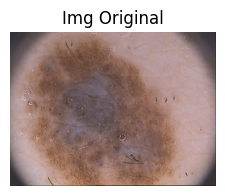

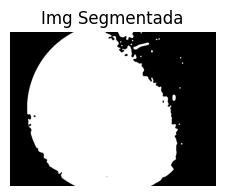

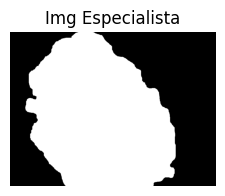

In [16]:
gera_tudo(bin_p_p_j,bin_np_p_j,bin_p_np_j,bin_np_np_j, 'Binarização', 'Jaccard')

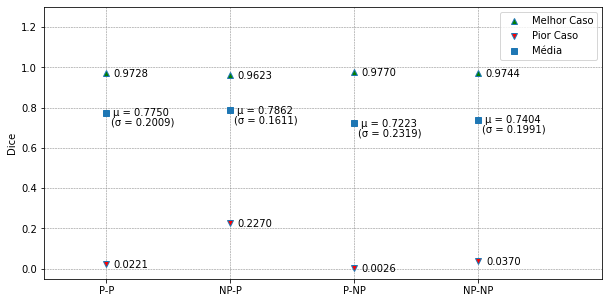

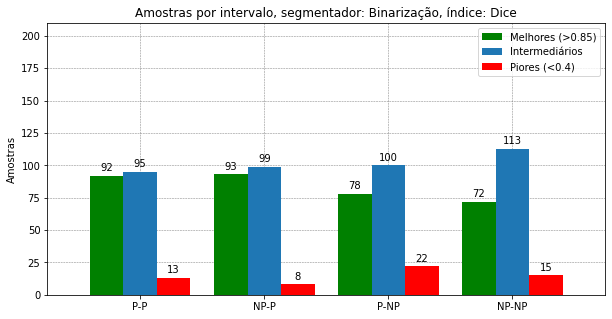


Binarização + Dice: 
Maior Média: 
NP_P
Maior número de melhores amostras: 
NP_P

Pior caso: 
Dice ->  0.2269818535405963 

IMD035


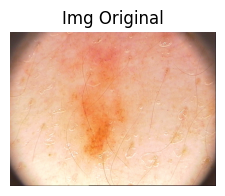

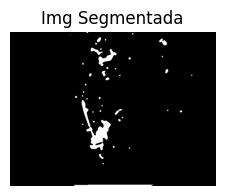

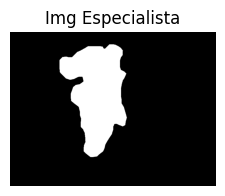


Melhor caso: 
Dice ->  0.9622936911607395 

IMD347


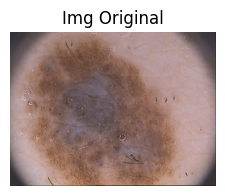

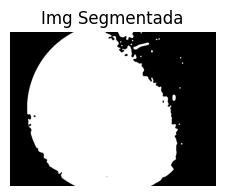

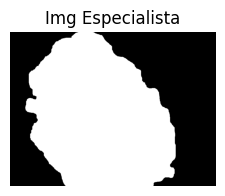

In [17]:
gera_tudo(bin_p_p_d,bin_np_p_d,bin_p_np_d,bin_np_np_d, 'Binarização', 'Dice', melhor=0.85, pior=0.40)

## Binarização Adaptativa Gauss

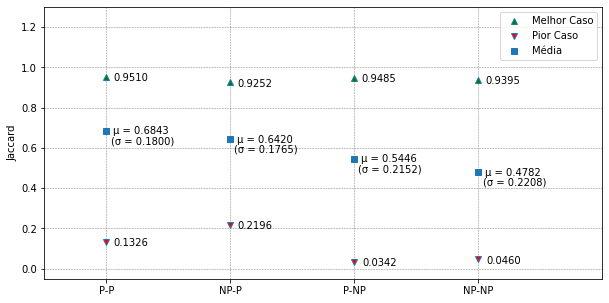

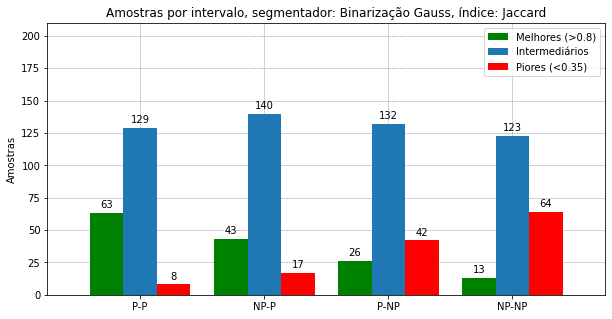


Binarização Gauss + Jaccard: 
Maior Média: 
P_P
Maior número de melhores amostras: 
P_P

Pior caso: 
Jaccard ->  0.1325933119789182 

IMD023


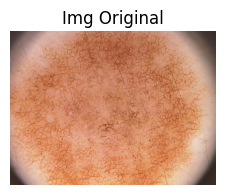

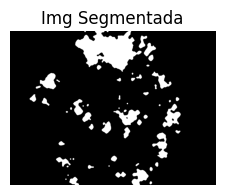

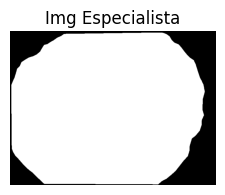


Melhor caso: 
Jaccard ->  0.950974270297965 

IMD171


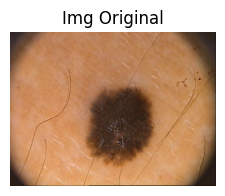

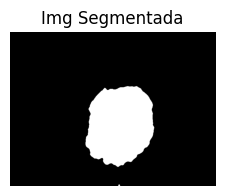

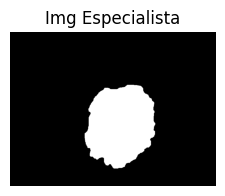

In [18]:
gera_tudo(binG_p_p_j,binG_np_p_j,binG_p_np_j,binG_np_np_j, 'Binarização Gauss', 'Jaccard')

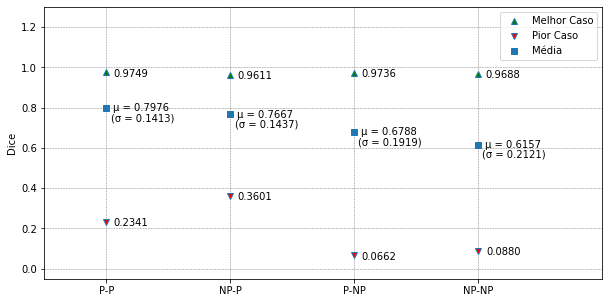

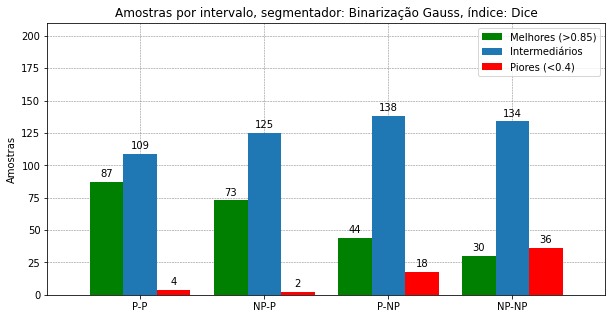


Binarização Gauss + Dice: 
Maior Média: 
P_P
Maior número de melhores amostras: 
P_P

Pior caso: 
Dice ->  0.23414108237535886 

IMD023


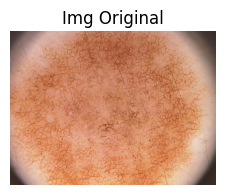

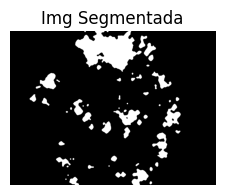

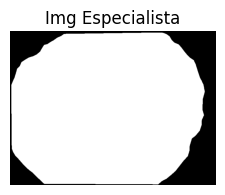


Melhor caso: 
Dice ->  0.9748711551718479 

IMD171


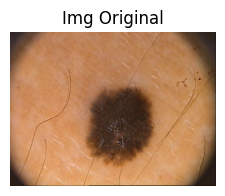

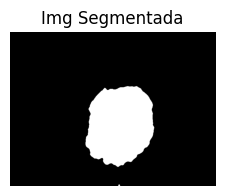

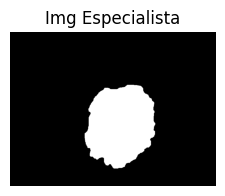

In [19]:
gera_tudo(binG_p_p_d,binG_np_p_d,binG_p_np_d,binG_np_np_d, 'Binarização Gauss', 'Dice', melhor=0.85, pior=0.4)

## Binarização Adaptativa Mean

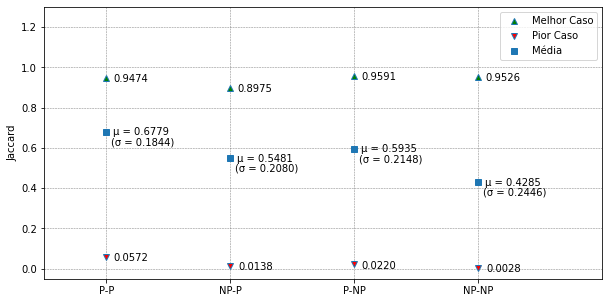

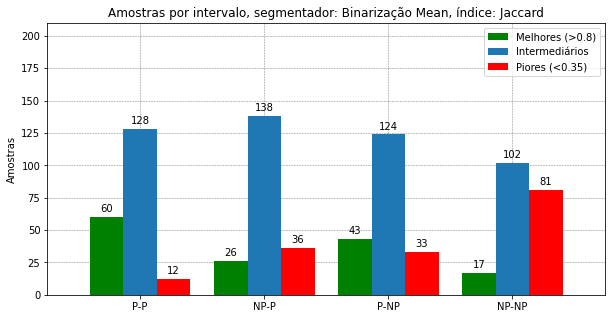


Binarização Mean + Jaccard: 
Maior Média: 
P_P
Maior número de melhores amostras: 
P_P

Pior caso: 
Jaccard ->  0.05716275962071564 

IMD023


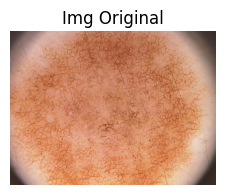

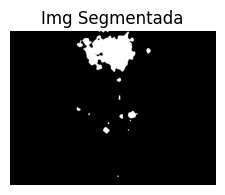

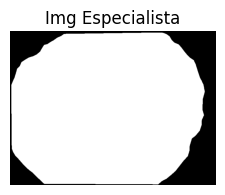


Melhor caso: 
Jaccard ->  0.9474421195003581 

IMD171


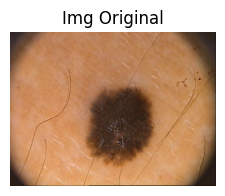

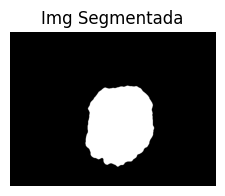

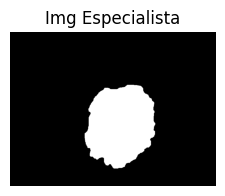

In [20]:
gera_tudo(binM_p_p_j,binM_np_p_j,binM_p_np_j,binM_np_np_j, 'Binarização Mean', 'Jaccard')

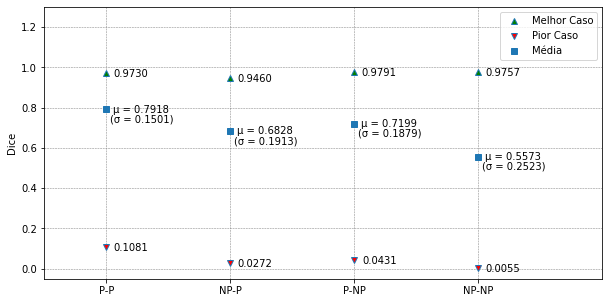

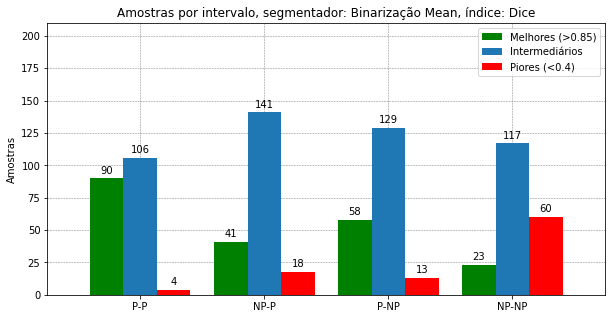


Binarização Mean + Dice: 
Maior Média: 
P_P
Maior número de melhores amostras: 
P_P

Pior caso: 
Dice ->  0.10814372545855522 

IMD023


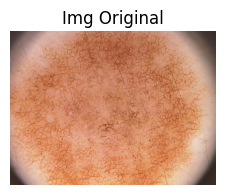

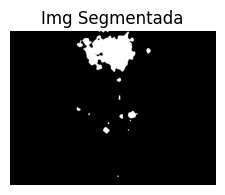

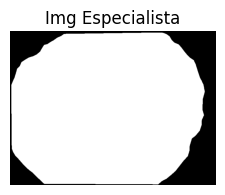


Melhor caso: 
Dice ->  0.9730118394927566 

IMD171


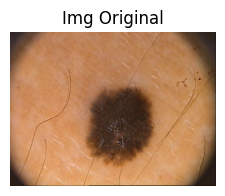

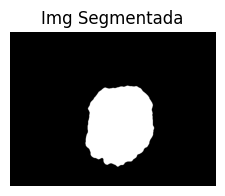

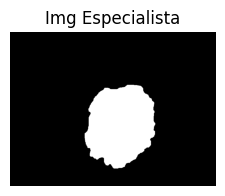

In [21]:
gera_tudo(binM_p_p_d,binM_np_p_d,binM_p_np_d,binM_np_np_d, 'Binarização Mean', 'Dice', melhor=0.85, pior=0.4)

## Crescimento de Região

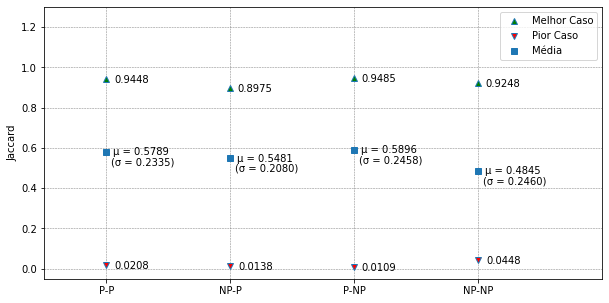

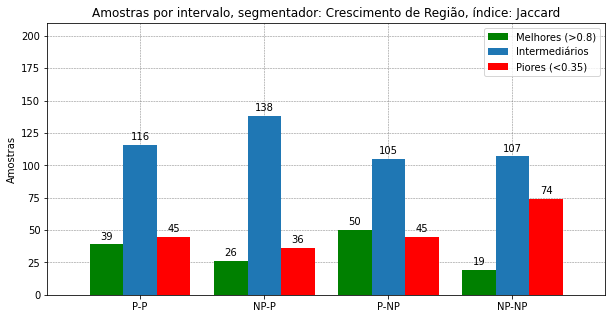


Crescimento de Região + Jaccard: 
Maior Média: 
P_NP
Maior número de melhores amostras: 
P_NP

Pior caso: 
Jaccard ->  0.010890934728963853 

IMD091


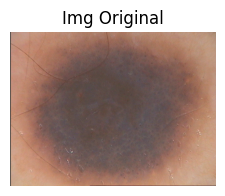

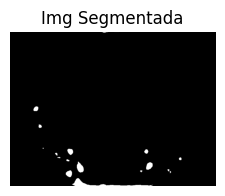

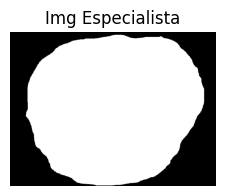


Melhor caso: 
Jaccard ->  0.9484813469792011 

IMD347


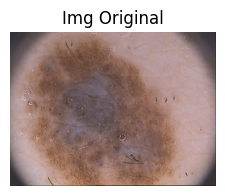

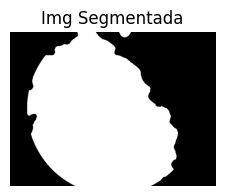

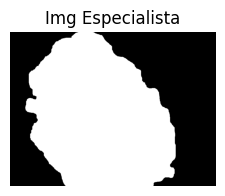

In [22]:
gera_tudo(cr_p_p_j,cr_np_p_j,cr_p_np_j,cr_np_np_j, 'Crescimento de Região', 'Jaccard')

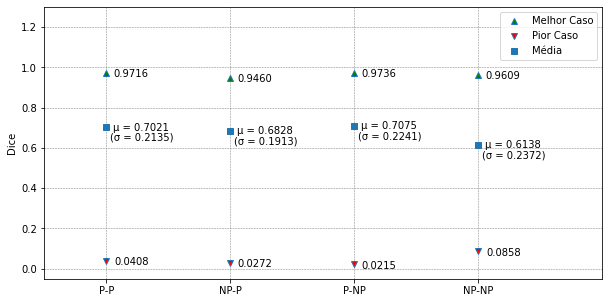

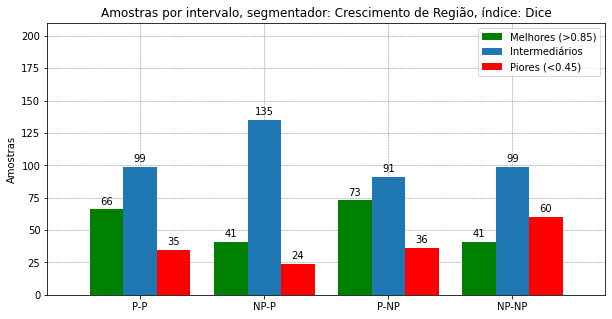


Crescimento de Região + Dice: 
Maior Média: 
P_NP
Maior número de melhores amostras: 
P_NP

Pior caso: 
Dice ->  0.02154720030580527 

IMD091


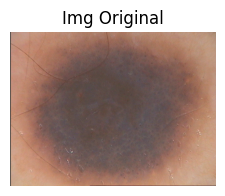

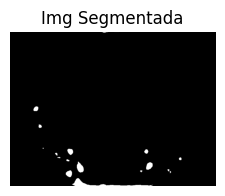

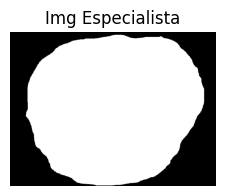


Melhor caso: 
Dice ->  0.9735595862384466 

IMD347


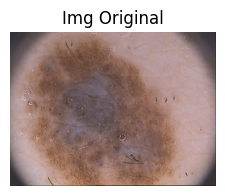

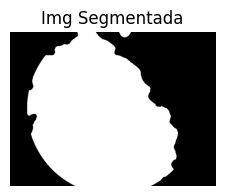

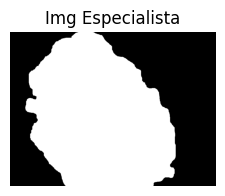

In [23]:
gera_tudo(cr_p_p_d,cr_np_p_d,cr_p_np_d,cr_np_np_d, 'Crescimento de Região', 'Dice', melhor=0.85, pior=0.45)

## Controle

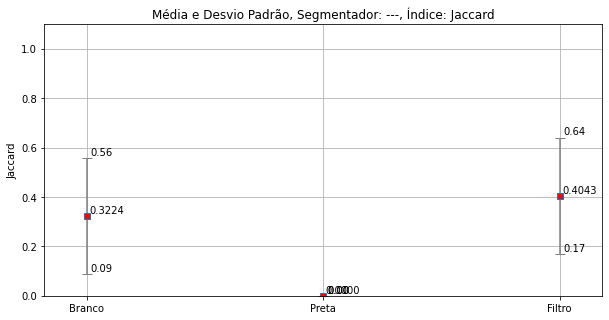

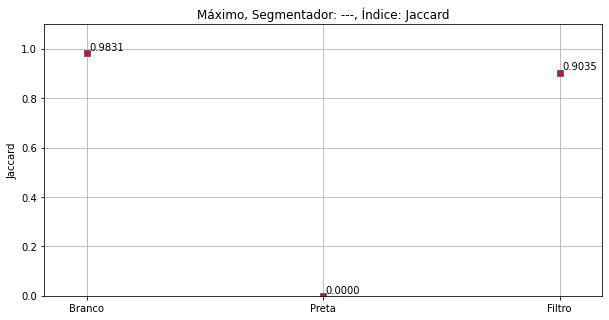

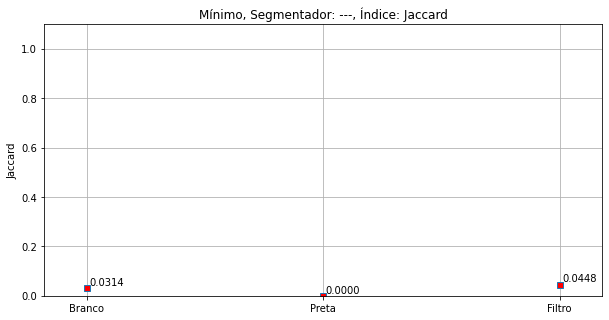

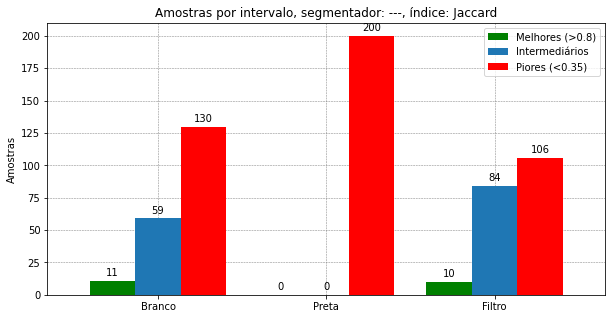

Jaccard: 
Maior Média: 
Filtro
Maior número de melhores amostras: 
Branco

Pior caso: 
Jaccard ->  0.044810421178524094 

IMD092


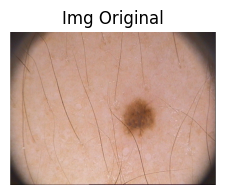

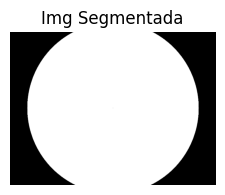

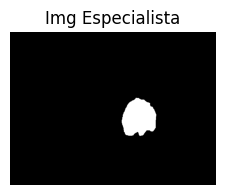


Melhor caso: 
Jaccard ->  0.9034757939165708 

IMD091


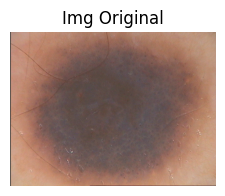

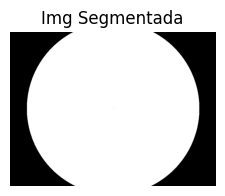

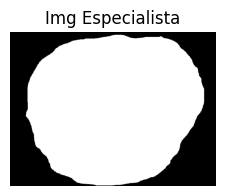

In [24]:
gera_tudo_controle(con_branco_j,con_preta_j,con_filtro_j, '---', 'Jaccard')

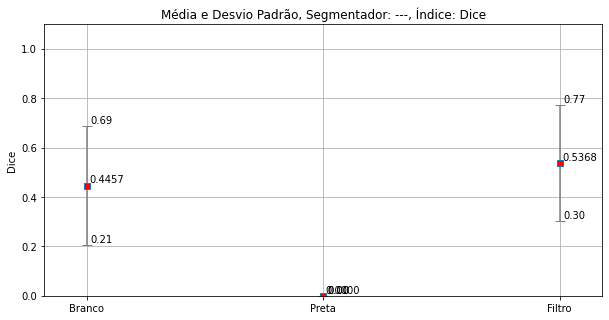

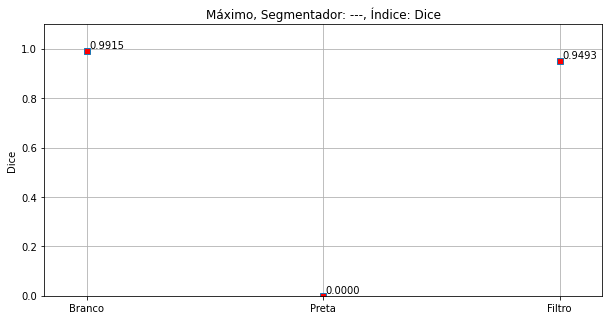

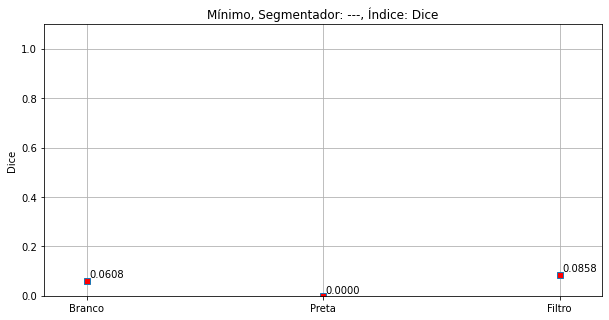

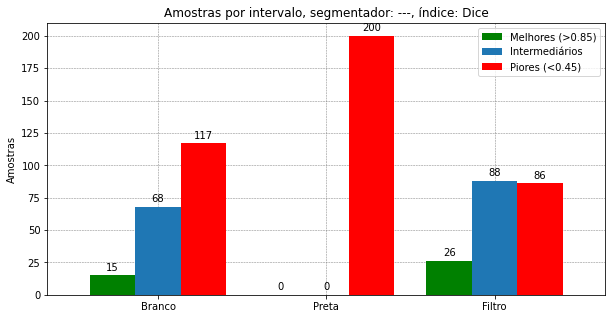

Dice: 
Maior Média: 
Filtro
Maior número de melhores amostras: 
Filtro

Pior caso: 
Dice ->  0.08577713290412799 

IMD092


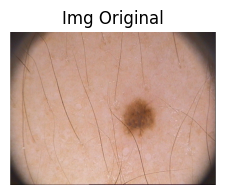

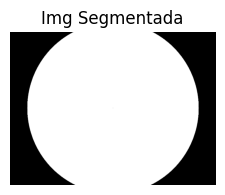

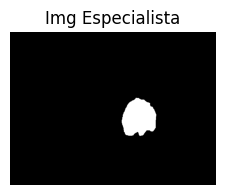


Melhor caso: 
Dice ->  0.9492905523716579 

IMD091


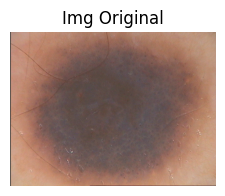

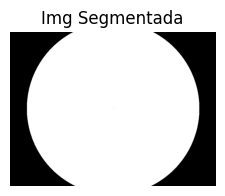

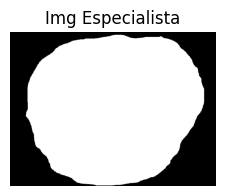

In [25]:
gera_tudo_controle(con_branco_d,con_preta_d,con_filtro_d, '---', 'Dice', melhor=0.85, pior=0.45)

# Melhores Experimentos

Kmeans + Jaccard: Média: NP_P e Maior número: P_P

Otsu + Jaccard: Média: P_P e Maior número: P_P

Binarização + Jaccard: Média: NP_P e Maior número: P_P

Binarização Gauss + Jaccard: Média: P_P e Maior número: P_P

Binarização Mean + Jaccard: Média: P_P e Maior número: P_P

Crescimento de Região + Jaccard: Média: NP_P e Maior número: P_NP

Controle + Jaccard: Média: Filtro e Maior número: Branco

##############################################

Kmeans + Dice: Média: NP_P e Maior número: P_P

Otsu + Dice: Média: NP_P e Maior número: P_P

Binarização + Dice: Média: NP_P e Maior número: NP_P

Binarização Gauss + Dice: Média: P_P e Maior número: P_P

Binarização Mean + Dice: Média: P_P e Maior número: P_P

Crescimento de Região + Dice: Média: NP_P e Maior número: NP_NP

Controle + Dice: Média: Filtro e Maior número: Filtro

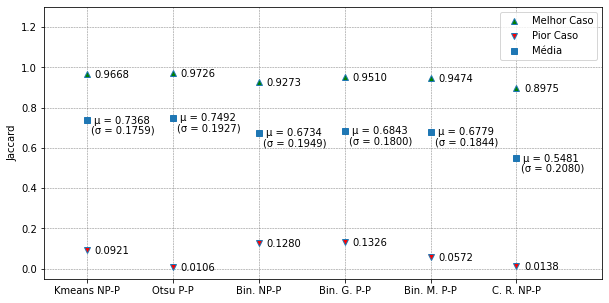

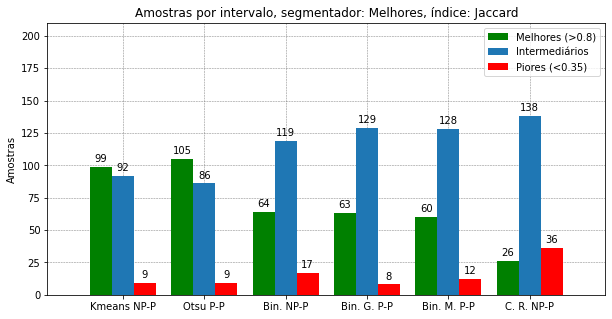

Jaccard: 
Maior Média: 
Otsu
P-P
Maior número de melhores amostras: 
Otsu

Pior caso: 
Jaccard ->  0.010611514533613533 

IMD010


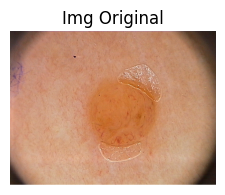

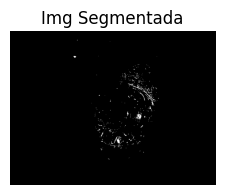

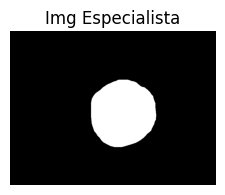


Melhor caso: 
Jaccard ->  0.972570297159672 

IMD057


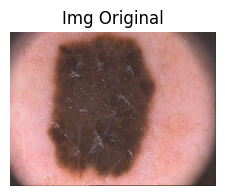

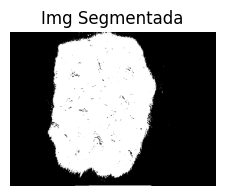

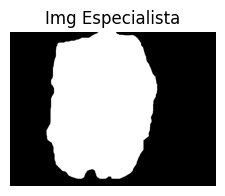

In [26]:
X = ['Kmeans NP-P', 'Otsu P-P', 'Bin. NP-P', 'Bin. G. P-P', 'Bin. M. P-P', 'C. R. NP-P']
gera_tudo_melhores(X, kmeans_np_p_j, otsu_p_p_j, bin_np_p_j, binG_p_p_j, binM_p_p_j, cr_np_p_j, 'Jaccard')

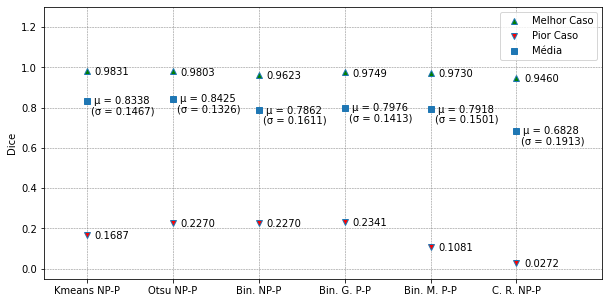

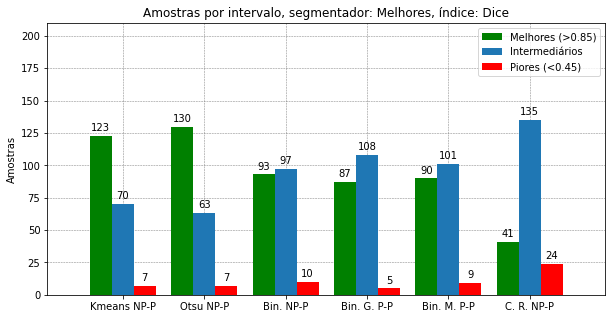

Dice: 
Maior Média: 
Otsu
NP-P
Maior número de melhores amostras: 
Otsu

Pior caso: 
Dice ->  0.2269818535405963 

IMD035


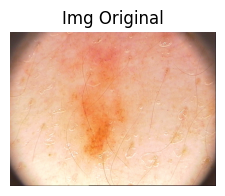

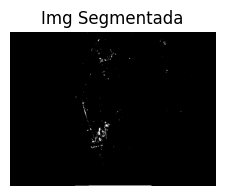

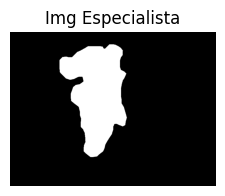


Melhor caso: 
Dice ->  0.9802712970363152 

IMD057


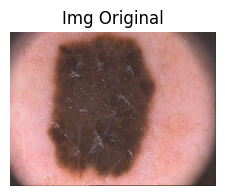

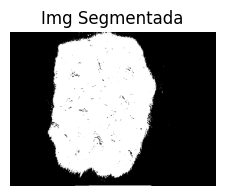

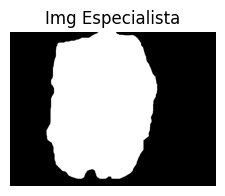

In [27]:
X = ['Kmeans NP-P', 'Otsu NP-P', 'Bin. NP-P', 'Bin. G. P-P', 'Bin. M. P-P', 'C. R. NP-P']
gera_tudo_melhores(X, kmeans_np_p_d, otsu_np_p_d, bin_np_p_d, binG_p_p_d, binM_p_p_d, cr_np_p_d, 'Dice', melhor=0.85, pior=0.45)